In [70]:
# Import các thư viện cần thiết
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import zscore
    from math import radians, sin, cos, sqrt, atan2
    print("Đã import thành công tất cả thư viện cần thiết")
except ImportError as e:
    print(f"Lỗi import thư viện: {str(e)}")
    print("Vui lòng cài đặt thư viện còn thiếu bằng pip install")

Đã import thành công tất cả thư viện cần thiết


In [71]:
# Đọc dữ liệu từ file uber.csv
print("=== ĐỌC DỮ LIỆU ===")
df = pd.read_csv(r'd:\predict taxi fares\uber.csv', index_col=0)  # Bỏ qua cột index

# Kiểm tra thông tin dữ liệu ban đầu
print("\n=== KIỂM TRA DỮ LIỆU BAN ĐẦU ===")
print("\nThông tin dữ liệu:")
print(df.info())

print("\nMẫu dữ liệu:")
print(df.head())

print("\nThống kê mô tả ban đầu:")
print(df.describe())

=== ĐỌC DỮ LIỆU ===

=== KIỂM TRA DỮ LIỆU BAN ĐẦU ===

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 24238194 to 11951496
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  object 
 1   fare_amount        200000 non-null  float64
 2   pickup_datetime    200000 non-null  object 
 3   pickup_longitude   200000 non-null  float64
 4   pickup_latitude    200000 non-null  float64
 5   dropoff_longitude  199999 non-null  float64
 6   dropoff_latitude   199999 non-null  float64
 7   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 13.7+ MB
None

Mẫu dữ liệu:
                                    key  fare_amount          pickup_datetime  \
24238194    2015-05-07 19:52:06.0000003          7.5  2015-05-07 19:52:06 UTC   
27835199    2009-07-17 20:04:56.0000002          7.7  2009-07-17 20:04:56 UTC 

In [72]:
# Kiểm tra và xử lý giá trị null
print("=== KIỂM TRA VÀ XỬ LÝ GIÁ TRỊ NULL ===\n")
print("Số lượng giá trị null trong từng cột:")
null_counts = df.isnull().sum()
print(null_counts)

print("\nPhần trăm giá trị null trong từng cột:")
null_percentages = (df.isnull().sum() / len(df)) * 100
print(null_percentages)

# Kiểm tra và xử lý giá trị 0 trong tọa độ
print("\n=== KIỂM TRA VÀ XỬ LÝ GIÁ TRỊ 0 TRONG TỌA ĐỘ ===\n")
zero_coords = df[(df['pickup_longitude'] == 0) | 
                (df['pickup_latitude'] == 0) |
                (df['dropoff_longitude'] == 0) |
                (df['dropoff_latitude'] == 0)]
print("Số lượng bản ghi có tọa độ bằng 0:", len(zero_coords))

# Thay thế giá trị 0 trong tọa độ bằng median
coord_columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
for col in coord_columns:
    median_value = df[df[col] != 0][col].median()
    df[col] = df[col].replace(0, median_value)

# Xử lý giá trị null
print("\n=== XỬ LÝ GIÁ TRỊ NULL ===\n")
df.fillna(df.median(numeric_only=True), inplace=True)

print("Kiểm tra giá trị null sau khi xử lý:")
print(df.isnull().sum())

=== KIỂM TRA VÀ XỬ LÝ GIÁ TRỊ NULL ===

Số lượng giá trị null trong từng cột:
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

Phần trăm giá trị null trong từng cột:
key                  0.0000
fare_amount          0.0000
pickup_datetime      0.0000
pickup_longitude     0.0000
pickup_latitude      0.0000
dropoff_longitude    0.0005
dropoff_latitude     0.0005
passenger_count      0.0000
dtype: float64

=== KIỂM TRA VÀ XỬ LÝ GIÁ TRỊ 0 TRONG TỌA ĐỘ ===

Số lượng bản ghi có tọa độ bằng 0: 3968

=== XỬ LÝ GIÁ TRỊ NULL ===

Kiểm tra giá trị null sau khi xử lý:
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0


In [73]:
# Chuyển đổi cột datetime và tạo features thời gian
print("=== CHUYỂN ĐỔI ĐỊNH DẠNG THỜI GIAN ===\n")
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Thêm các đặc trưng thời gian
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year

print("Các đặc trưng thời gian đã thêm:")
print(df[['hour', 'day', 'month', 'year']].head())

# Định nghĩa hàm tính khoảng cách
def haversine_distance(lat1, lon1, lat2, lon2):
    """Tính khoảng cách giữa hai điểm trên trái đất"""
    R = 6371  # Bán kính trái đất (km)
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    
    return distance

# Tính khoảng cách chuyến đi
df['trip_distance'] = df.apply(lambda row: haversine_distance(
    row['pickup_latitude'], row['pickup_longitude'],
    row['dropoff_latitude'], row['dropoff_longitude']
), axis=1)

=== CHUYỂN ĐỔI ĐỊNH DẠNG THỜI GIAN ===

Các đặc trưng thời gian đã thêm:
          hour  day  month  year
24238194    19    7      5  2015
27835199    20   17      7  2009
44984355    21   24      8  2009
25894730     8   26      6  2009
17610152    17   28      8  2014
Các đặc trưng thời gian đã thêm:
          hour  day  month  year
24238194    19    7      5  2015
27835199    20   17      7  2009
44984355    21   24      8  2009
25894730     8   26      6  2009
17610152    17   28      8  2014


In [74]:
# Xử lý dữ liệu không hợp lý
print("=== XỬ LÝ DỮ LIỆU KHÔNG HỢP LÝ ===\n")

# 1. Xử lý giá cước không hợp lý
print("Số chuyến có giá cước <= 0:", len(df[df['fare_amount'] <= 0]))
df = df[df['fare_amount'] > 0]

# 2. Xử lý passenger_count không hợp lý
print("\nPhân bố passenger_count trước khi xử lý:")
print(df['passenger_count'].value_counts().sort_index())
df = df[df['passenger_count'].between(1, 6)]

# 3. Xử lý chuyến đi có điểm đón/trả trùng nhau
duplicate_locations = df[df.apply(lambda row: 
    row['pickup_latitude'] == row['dropoff_latitude'] and 
    row['pickup_longitude'] == row['dropoff_longitude'], axis=1)]
print("\nSố chuyến có điểm đón/trả trùng nhau:", len(duplicate_locations))
df = df[df.apply(lambda row: 
    not (row['pickup_latitude'] == row['dropoff_latitude'] and 
         row['pickup_longitude'] == row['dropoff_longitude']), axis=1)]

# 4. Lọc các chuyến đi quá xa
print("\nThống kê khoảng cách chuyến đi:")
print(df['trip_distance'].describe())
df = df[df['trip_distance'] <= df['trip_distance'].quantile(0.99)]  # Lọc bỏ 1% chuyến xa nhất

=== XỬ LÝ DỮ LIỆU KHÔNG HỢP LÝ ===

Số chuyến có giá cước <= 0: 22

Phân bố passenger_count trước khi xử lý:
passenger_count
0         709
1      138414
2       29424
3        8878
4        4276
5       14005
6        4271
208         1
Name: count, dtype: int64

Số chuyến có điểm đón/trả trùng nhau: 2043

Số chuyến có điểm đón/trả trùng nhau: 2043

Thống kê khoảng cách chuyến đi:
count    197225.000000
mean          5.077551
std         103.672970
min           0.000084
25%           1.238139
50%           2.141854
75%           3.890996
max       16409.239135
Name: trip_distance, dtype: float64

Thống kê khoảng cách chuyến đi:
count    197225.000000
mean          5.077551
std         103.672970
min           0.000084
25%           1.238139
50%           2.141854
75%           3.890996
max       16409.239135
Name: trip_distance, dtype: float64


In [75]:
# Xử lý ngoại lai
print("=== Xử LÝ NGOẠI LAI ===\n")

# Chọn các cột số
numeric_cols = ['fare_amount', 'pickup_longitude', 'pickup_latitude', 
                'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

print("Thống kê trước khi xử lý ngoại lai:")
print(df[numeric_cols].describe())

# Lọc ngoại lai một cách an toàn hơn
df_cleaned = df.copy()

# Xử lý outliers cho fare_amount
Q1 = df_cleaned['fare_amount'].quantile(0.05)  # Sử dụng phần trăm thứ 5
Q3 = df_cleaned['fare_amount'].quantile(0.95)  # Sử dụng phần trăm thứ 95
IQR = Q3 - Q1

df_cleaned = df_cleaned[
    (df_cleaned['fare_amount'] >= Q1 - 1.5 * IQR) & 
    (df_cleaned['fare_amount'] <= Q3 + 1.5 * IQR)
]

# Lọc các chuyến có khoảng cách không hợp lý (quá xa hoặc bằng 0)
df_cleaned = df_cleaned[
    (df_cleaned['trip_distance'] > 0) & 
    (df_cleaned['trip_distance'] <= df_cleaned['trip_distance'].quantile(0.99))
]

# Lọc các chuyến có tốc độ không hợp lý
df_cleaned['speed'] = df_cleaned['trip_distance'] / ((df_cleaned['trip_distance']/30) + 0.1)
df_cleaned = df_cleaned[df_cleaned['speed'] <= 100]  # Tăng giới hạn tốc độ lên 100km/h

print(f"\nSố lượng bản ghi ban đầu: {len(df)}")
print(f"Số lượng bản ghi sau khi xử lý ngoại lai: {len(df_cleaned)}")
print(f"Tỷ lệ dữ liệu giữ lại: {len(df_cleaned)/len(df)*100:.2f}%")

# Hiển thị thống kê sau khi xử lý
print("\nThống kê sau khi xử lý ngoại lai:")
print(df_cleaned[numeric_cols].describe())

=== Xử LÝ NGOẠI LAI ===

Thống kê trước khi xử lý ngoại lai:
         fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  195252.000000     195252.000000    195252.000000      195252.000000   
mean       10.967078        -73.913956        40.691217         -73.912707   
std         8.834095          2.637611         2.581344           2.637620   
min         0.010000        -75.387785       -74.015515         -75.417737   
25%         6.000000        -73.992134        40.737122         -73.991449   
50%         8.500000        -73.982101        40.753282         -73.980517   
75%        12.500000        -73.969180        40.767216         -73.966324   
max       499.000000         40.808425        45.031653          40.831932   

       dropoff_latitude  passenger_count  
count     195252.000000    195252.000000  
mean          40.691335         1.688597  
std            2.581528         1.305053  
min          -74.015750         1.000000  
25%           40.7361

In [76]:
# Xử lý outliers sử dụng phương pháp IQR
def remove_outliers_iqr(df, columns, k=1.5):
    df_clean = df.copy()
    
    for column in columns:
        Q1 = df_clean[column].quantile(0.25)
        Q3 = df_clean[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR
        
        df_clean = df_clean[
            (df_clean[column] >= lower_bound) & 
            (df_clean[column] <= upper_bound)
        ]
        
        print(f'Column {column}:')
        print(f'- Lower bound: {lower_bound:.2f}')
        print(f'- Upper bound: {upper_bound:.2f}')
        print(f'- Records removed: {len(df) - len(df_clean)}\n')
    
    return df_clean

# Áp dụng xử lý outliers cho từng nhóm dữ liệu
print('=== Xử LÝ OUTLIERS SỬ DỤNG PHƯƠNG PHÁP IQR ====')

# Xử lý outliers cho fare_amount theo nhóm khoảng cách
df_cleaned['distance_group'] = pd.qcut(df_cleaned['trip_distance'], q=5, labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])

df_cleaned_v2 = pd.DataFrame()
for group in df_cleaned['distance_group'].unique():
    group_data = df_cleaned[df_cleaned['distance_group'] == group]
    cleaned_group = remove_outliers_iqr(group_data, ['fare_amount'], k=2)
    df_cleaned_v2 = pd.concat([df_cleaned_v2, cleaned_group])

print(f'Số bản ghi sau khi xử lý outliers theo nhóm: {len(df_cleaned_v2)}')

=== Xử LÝ OUTLIERS SỬ DỤNG PHƯƠNG PHÁP IQR ====
Column fare_amount:
- Lower bound: 0.90
- Upper bound: 11.90
- Records removed: 921

Column fare_amount:
- Lower bound: 2.10
- Upper bound: 14.10
- Records removed: 941

Column fare_amount:
- Lower bound: -7.00
- Upper bound: 45.50
- Records removed: 528

Column fare_amount:
- Lower bound: 0.30
- Upper bound: 9.80
- Records removed: 2743

Column fare_amount:
- Lower bound: 0.30
- Upper bound: 9.80
- Records removed: 2743

Column fare_amount:
- Lower bound: 1.70
- Upper bound: 19.70
- Records removed: 676

Số bản ghi sau khi xử lý outliers theo nhóm: 187158
Column fare_amount:
- Lower bound: 1.70
- Upper bound: 19.70
- Records removed: 676

Số bản ghi sau khi xử lý outliers theo nhóm: 187158


In [77]:
# Phân tích và xử lý dữ liệu nâng cao
print("=== PHÂN TÍCH VÀ XỬ LÝ DỮ LIỆU NÂNG CAO ===\n")

# 1. Xử lý outliers theo logic nghiệp vụ
print("1. Xử lý outliers theo logic nghiệp vụ...")

# Lọc giá cước hợp lý (từ 2.5$ đến 200$)
df_cleaned = df_cleaned[(df_cleaned['fare_amount'] >= 2.5) & (df_cleaned['fare_amount'] <= 200)]

# Lọc khoảng cách hợp lý (0.1km đến 100km)
df_cleaned = df_cleaned[(df_cleaned['trip_distance'] >= 0.1) & (df_cleaned['trip_distance'] <= 100)]

# Tính và lọc theo tốc độ trung bình
df_cleaned['avg_speed'] = df_cleaned['trip_distance'] / ((df_cleaned['trip_distance']/30) + 0.1)  # km/h
df_cleaned = df_cleaned[df_cleaned['avg_speed'] <= 80]  # Giới hạn tốc độ tối đa 80km/h

# 2. Tạo features mới
print("\n2. Tạo features mới...")

# Features thời gian
df_cleaned['is_weekend'] = df_cleaned['pickup_datetime'].dt.weekday.isin([5, 6]).astype(int)
df_cleaned['is_rush_hour'] = (
    ((df_cleaned['hour'] >= 7) & (df_cleaned['hour'] <= 10)) | 
    ((df_cleaned['hour'] >= 16) & (df_cleaned['hour'] <= 19))
).astype(int)
df_cleaned['day_of_week'] = df_cleaned['pickup_datetime'].dt.dayofweek

# Features khoảng cách
df_cleaned['manhattan_distance'] = (
    abs(df_cleaned['dropoff_longitude'] - df_cleaned['pickup_longitude']) +
    abs(df_cleaned['dropoff_latitude'] - df_cleaned['pickup_latitude'])
) * 111  # Chuyển đổi sang km

# Features giá/khoảng cách
df_cleaned['fare_per_km'] = df_cleaned['fare_amount'] / df_cleaned['trip_distance']
df_cleaned = df_cleaned[df_cleaned['fare_per_km'] <= 50]  # Giới hạn giá/km hợp lý

=== PHÂN TÍCH VÀ XỬ LÝ DỮ LIỆU NÂNG CAO ===

1. Xử lý outliers theo logic nghiệp vụ...

2. Tạo features mới...


=== FEATURE ENGINEERING VÀ PHÂN TÍCH Dữ LIỆU ===

1. Tạo các features mới...

3. Phân tích tương quan giữa các biến...

3. Phân tích tương quan giữa các biến...


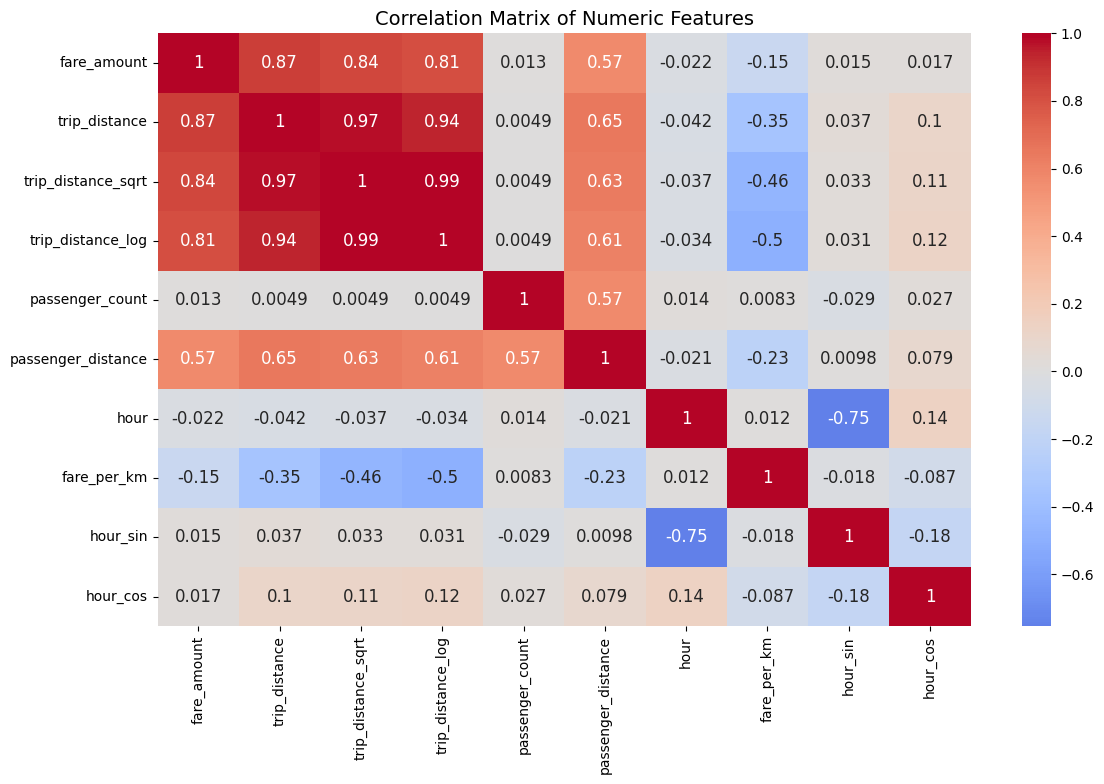


4. Lưu dữ liệu đã xử lý...

Số lượng features cuối cùng: 14
Số lượng bản ghi cuối cùng: 189405

Thống kê mô tả dữ liệu cuối cùng:

Số lượng features cuối cùng: 14
Số lượng bản ghi cuối cùng: 189405

Thống kê mô tả dữ liệu cuối cùng:
         fare_amount  trip_distance  trip_distance_sqrt  trip_distance_log  \
count  189405.000000  189405.000000       189405.000000      189405.000000   
mean       10.380954       2.994551            1.599655           1.223529   
std         7.014269       2.614896            0.660044           0.542620   
min         2.500000       0.100227            0.316586           0.095517   
25%         6.000000       1.264016            1.124285           0.817140   
50%         8.100000       2.136494            1.461675           1.143106   
75%        12.100000       3.767167            1.940919           1.561752   
max        63.500000      16.785448            4.097005           2.878381   

       passenger_count  passenger_distance           hour      

In [78]:
# Feature engineering và phân tích dữ liệu
print('=== FEATURE ENGINEERING VÀ PHÂN TÍCH Dữ LIỆU ===')

# 1. Tạo features mới
print('\n1. Tạo các features mới...')

# Biến đổi cho trip_distance (chỉ giữ sqrt và log)
df_cleaned['trip_distance_sqrt'] = np.sqrt(df_cleaned['trip_distance'])
df_cleaned['trip_distance_log'] = np.log1p(df_cleaned['trip_distance'])

# Features thời gian cơ bản
df_cleaned['hour_sin'] = np.sin(2 * np.pi * df_cleaned['hour']/24)
df_cleaned['hour_cos'] = np.cos(2 * np.pi * df_cleaned['hour']/24)

# Features tương tác chọn lọc
df_cleaned['passenger_distance'] = df_cleaned['passenger_count'] * df_cleaned['trip_distance']

# 2. Tạo nhóm cho trip_distance và fare_amount
df_cleaned['distance_group'] = pd.qcut(df_cleaned['trip_distance'], q=5, 
                                      labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])

# Tính giá/km và tạo nhóm
df_cleaned['fare_per_km'] = df_cleaned['fare_amount'] / df_cleaned['trip_distance']
df_cleaned['fare_per_km_group'] = pd.qcut(df_cleaned['fare_per_km'], q=5,
                                         labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# 3. Phân tích tương quan
print('\n3. Phân tích tương quan giữa các biến...')
numeric_cols = [
    'fare_amount', 
    'trip_distance', 'trip_distance_sqrt', 'trip_distance_log',
    'passenger_count', 'passenger_distance',
    'hour', 'fare_per_km',
    'hour_sin', 'hour_cos'
]

# Tính toán ma trận tương quan
corr_matrix = df_cleaned[numeric_cols].corr()

# Vẽ heatmap tương quan
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.savefig('correlation_base_features.png')
plt.show()

# 4. Lưu dữ liệu đã xử lý
print('\n4. Lưu dữ liệu đã xử lý...')

# Chọn các cột cần lưu
columns_to_save = [
    # Biến mục tiêu
    'fare_amount',
    
    # Features khoảng cách
    'trip_distance', 'trip_distance_sqrt', 'trip_distance_log',
    
    # Features hành khách
    'passenger_count', 'passenger_distance',
    
    # Features thời gian
    'hour', 'day', 'month', 'year',
    'hour_sin', 'hour_cos',
    'is_weekend', 'is_rush_hour'
]

# Lưu dữ liệu
df_final = df_cleaned[columns_to_save]
df_final.to_csv('uber_cleaned.csv', index=False)

print(f'\nSố lượng features cuối cùng: {len(columns_to_save)}')
print(f'Số lượng bản ghi cuối cùng: {len(df_final)}')

print('\nThống kê mô tả dữ liệu cuối cùng:')
print(df_final.describe())

In [79]:
# Feature Engineering nâng cao
print('=== FEATURE ENGINEERING NÂNG CAO ===')

# 1. Tạo các features cơ bản
print('\n1. Tạo các features cơ bản...')

# Features thời gian cơ bản
df_cleaned_v2['is_weekend'] = df_cleaned_v2['pickup_datetime'].dt.weekday.isin([5, 6]).astype(int)
df_cleaned_v2['is_rush_hour'] = (
    ((df_cleaned_v2['hour'] >= 7) & (df_cleaned_v2['hour'] <= 10)) | 
    ((df_cleaned_v2['hour'] >= 16) & (df_cleaned_v2['hour'] <= 19))
).astype(int)

# 2. Biến đổi phi tuyến cho trip_distance
print('\n2. Tạo biến đổi phi tuyến cho trip_distance...')
df_cleaned_v2['trip_distance_squared'] = df_cleaned_v2['trip_distance'] ** 2
df_cleaned_v2['trip_distance_sqrt'] = np.sqrt(df_cleaned_v2['trip_distance'])
df_cleaned_v2['trip_distance_log'] = np.log1p(df_cleaned_v2['trip_distance'])

# 3. Xử lý thời gian chi tiết hơn
print('\n3. Tạo features thời gian mới...')
df_cleaned_v2['hour_sin'] = np.sin(2 * np.pi * df_cleaned_v2['hour']/24)
df_cleaned_v2['hour_cos'] = np.cos(2 * np.pi * df_cleaned_v2['hour']/24)

df_cleaned_v2['time_period'] = pd.cut(
    df_cleaned_v2['hour'],
    bins=[-1, 5, 11, 16, 20, 24],
    labels=['Late Night', 'Morning', 'Afternoon', 'Evening', 'Night']
)

# One-hot encoding cho time_period
time_period_dummies = pd.get_dummies(df_cleaned_v2['time_period'], prefix='time')
df_cleaned_v2 = pd.concat([df_cleaned_v2, time_period_dummies], axis=1)

# 4. Features tương tác
print('\n4. Tạo features tương tác...')
df_cleaned_v2['passenger_distance'] = df_cleaned_v2['passenger_count'] * df_cleaned_v2['trip_distance']
df_cleaned_v2['rush_hour_distance'] = df_cleaned_v2['is_rush_hour'] * df_cleaned_v2['trip_distance']
df_cleaned_v2['weekend_distance'] = df_cleaned_v2['is_weekend'] * df_cleaned_v2['trip_distance']

# 5. Chuẩn hóa giá cước
print('\n5. Chuẩn hóa giá cước...')
df_cleaned_v2['fare_amount_log'] = np.log1p(df_cleaned_v2['fare_amount'])

# 6. Tạo nhóm giá/km
print('\n6. Tạo nhóm giá/km...')
df_cleaned_v2['fare_per_km'] = df_cleaned_v2['fare_amount'] / df_cleaned_v2['trip_distance']
df_cleaned_v2['fare_per_km_group'] = pd.qcut(
    df_cleaned_v2['fare_per_km'],
    q=5,
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
)

# One-hot encoding cho fare_per_km_group
fare_group_dummies = pd.get_dummies(df_cleaned_v2['fare_per_km_group'], prefix='fare_group')
df_cleaned_v2 = pd.concat([df_cleaned_v2, fare_group_dummies], axis=1)

# Hiển thị thông tin về features đã tạo
print('\nDanh sách các features đã tạo:')
print(df_cleaned_v2.columns.tolist())

print('\nThông tin về dữ liệu sau khi tạo features:')
print(df_cleaned_v2.info())

=== FEATURE ENGINEERING NÂNG CAO ===

1. Tạo các features cơ bản...

2. Tạo biến đổi phi tuyến cho trip_distance...

3. Tạo features thời gian mới...

3. Tạo features thời gian mới...

4. Tạo features tương tác...

5. Chuẩn hóa giá cước...

6. Tạo nhóm giá/km...

4. Tạo features tương tác...

5. Chuẩn hóa giá cước...

6. Tạo nhóm giá/km...

Danh sách các features đã tạo:
['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour', 'day', 'month', 'year', 'trip_distance', 'speed', 'distance_group', 'is_weekend', 'is_rush_hour', 'trip_distance_squared', 'trip_distance_sqrt', 'trip_distance_log', 'hour_sin', 'hour_cos', 'time_period', 'time_Late Night', 'time_Morning', 'time_Afternoon', 'time_Evening', 'time_Night', 'passenger_distance', 'rush_hour_distance', 'weekend_distance', 'fare_amount_log', 'fare_per_km', 'fare_per_km_group', 'fare_group_Very Low', 'fare_group_Low', 'fare_group_Medium', 'fare_gr

=== PHÂN TÍCH TƯƠNG QUAN ===



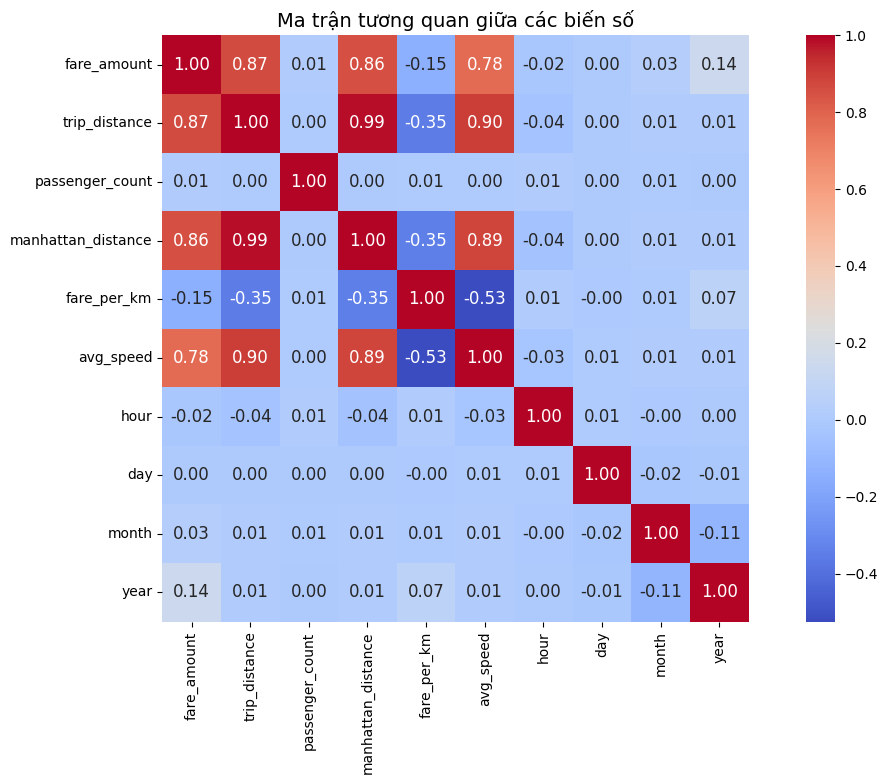


Các features có tương quan mạnh với fare_amount (|r| > 0.1):
trip_distance: 0.867
manhattan_distance: 0.856
avg_speed: 0.778
fare_per_km: 0.147
year: 0.137


In [80]:
# Feature selection dựa trên tương quan
print("=== PHÂN TÍCH TƯƠNG QUAN ===\n")

# Chọn các cột số để phân tích
numeric_cols = ['fare_amount', 'trip_distance', 'passenger_count', 
                'manhattan_distance', 'fare_per_km', 'avg_speed',
                'hour', 'day', 'month', 'year']

# Tính ma trận tương quan
correlation_matrix = df_cleaned[numeric_cols].corr()

# Vẽ heatmap tương quan
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, 
            annot=True,
            cmap='coolwarm',
            fmt='.2f',
            square=True)
plt.title('Ma trận tương quan giữa các biến số')
plt.tight_layout()
plt.show()

# Lọc features có tương quan cao với fare_amount
correlation_with_target = abs(correlation_matrix['fare_amount']).sort_values(ascending=False)
strong_corr_features = correlation_with_target[correlation_with_target > 0.1].index.tolist()
strong_corr_features.remove('fare_amount')

print("\nCác features có tương quan mạnh với fare_amount (|r| > 0.1):")
for feature in strong_corr_features:
    print(f"{feature}: {correlation_with_target[feature]:.3f}")

=== PHÂN TÍCH ĐA CỘNG TUYẾN VÀ TƯƠNG QUAN CẢI TIẾN ===



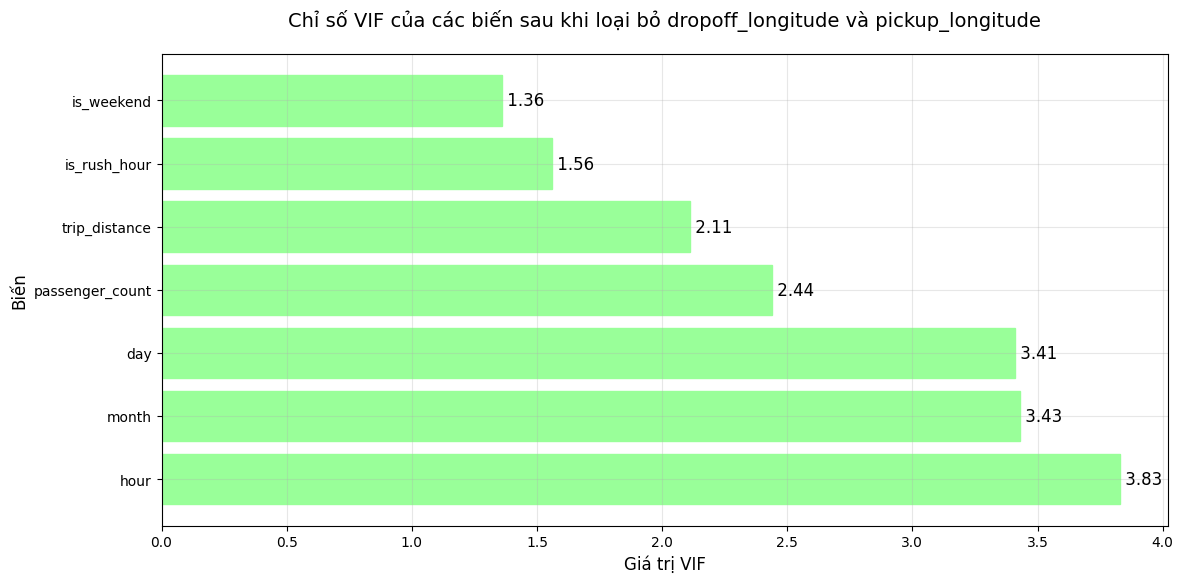


Kết quả phân tích VIF sau khi loại bỏ dropoff_longitude và pickup_longitude:

        Feature  VIF  Mức độ đa cộng tuyến
           hour 3.83 Thấp (Chấp nhận được)
          month 3.43 Thấp (Chấp nhận được)
            day 3.41 Thấp (Chấp nhận được)
passenger_count 2.44 Thấp (Chấp nhận được)
  trip_distance 2.11 Thấp (Chấp nhận được)
   is_rush_hour 1.56 Thấp (Chấp nhận được)
     is_weekend 1.36 Thấp (Chấp nhận được)


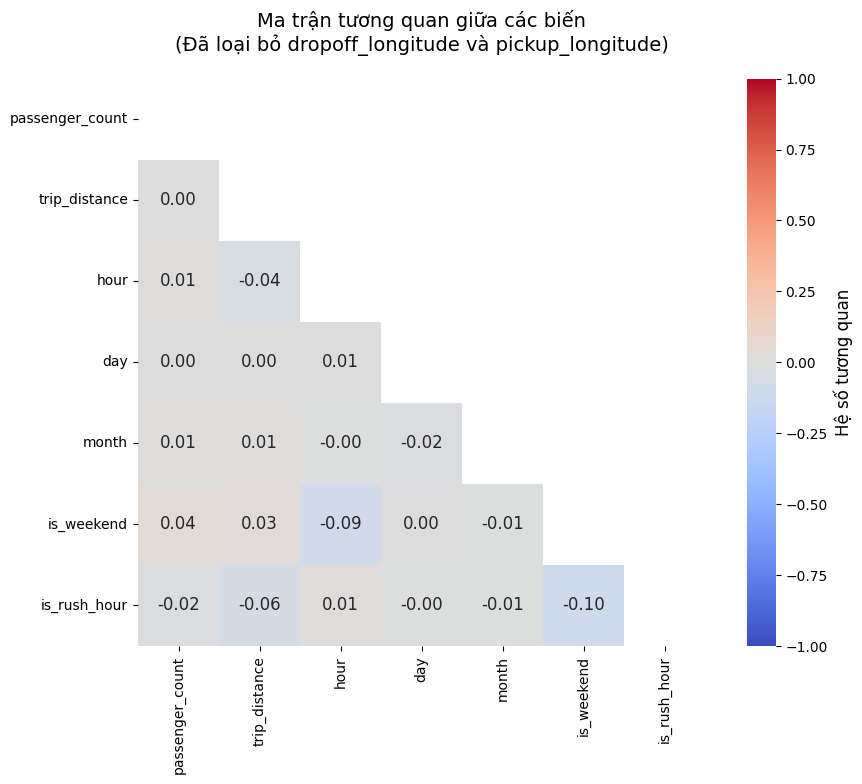


Các features được giữ lại sau khi xử lý đa cộng tuyến:
Phân tích VIF sau khi loại bỏ dropoff_longitude và pickup_longitude:


Bảng phân tích VIF:
------------------------------------------------------------
Feature                     VIF                    Mức độ
------------------------------------------------------------
hour                       3.83                      Thấp
month                      3.43                      Thấp
day                        3.41                      Thấp
passenger_count            2.44                      Thấp
trip_distance              2.11                      Thấp
is_rush_hour               1.56                      Thấp
is_weekend                 1.36                      Thấp

Bảng phân tích VIF:
------------------------------------------------------------
Feature                     VIF                    Mức độ
------------------------------------------------------------
hour                       3.83                      Thấp
month   

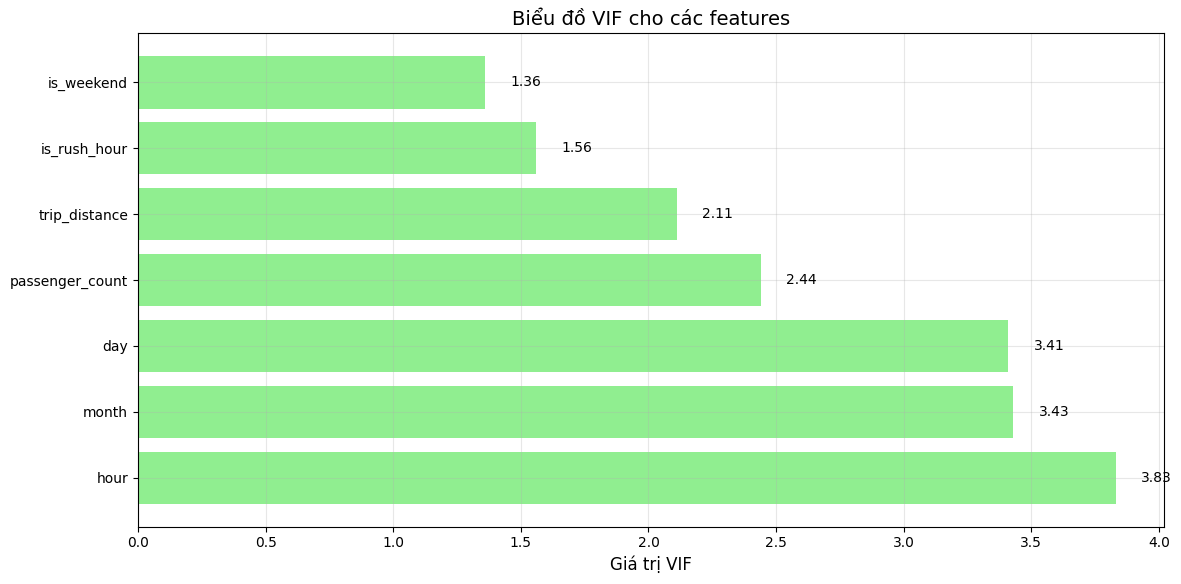

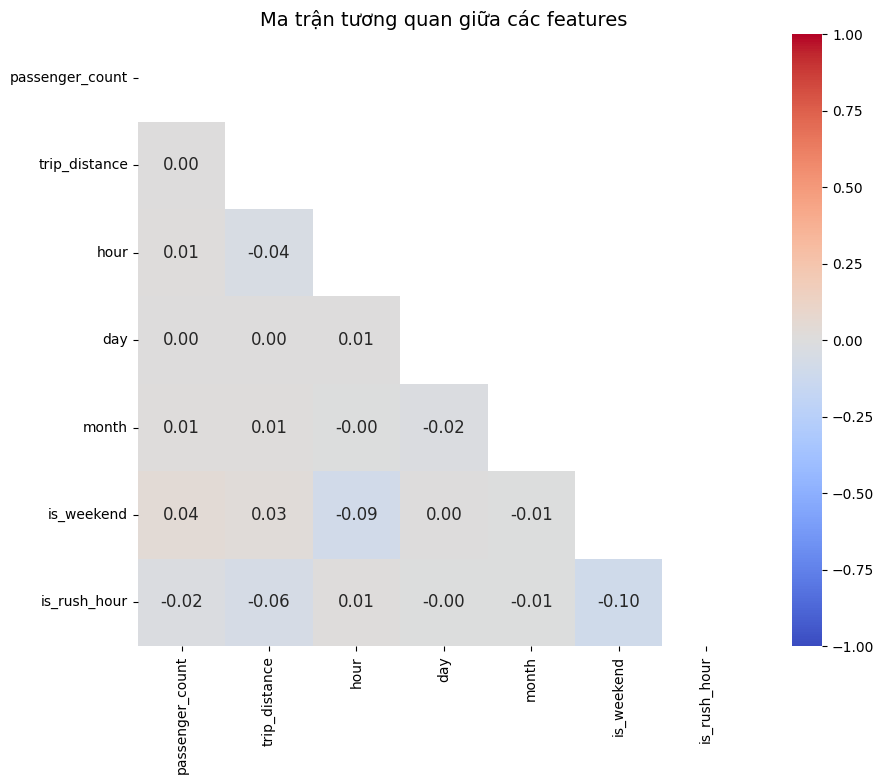


Kết luận về đa cộng tuyến:
- Không còn vấn đề đa cộng tuyến nghiêm trọng trong dữ liệu!


In [81]:
# Import thư viện cần thiết cho phân tích VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Phân tích đa cộng tuyến cải tiến
print('=== PHÂN TÍCH ĐA CỘNG TUYẾN VÀ TƯƠNG QUAN CẢI TIẾN ===\n')

# 1. Định nghĩa hàm tính VIF với định dạng số cải tiến
def calculate_vif_improved(df, features):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = features
    vif_data['VIF'] = [variance_inflation_factor(df[features].values, i) for i in range(len(features))]
    vif_data['VIF'] = vif_data['VIF'].apply(lambda x: f'{x:,.2f}')
    vif_data['VIF'] = vif_data['VIF'].str.replace(',', '').astype(float)
    
    def get_collinearity_level(vif):
        if vif < 5:
            return 'Thấp (Chấp nhận được)'
        elif vif < 10:
            return 'Trung bình (Cần xem xét)'
        else:
            return 'Cao (Cần loại bỏ)'
    
    vif_data['Mức độ đa cộng tuyến'] = vif_data['VIF'].apply(get_collinearity_level)
    return vif_data

# 2. Chọn các features cuối cùng (đã loại bỏ tất cả các biến tọa độ vì VIF cao)
initial_features = [
    'passenger_count', 'trip_distance',
    'hour', 'day', 'month',
    'is_weekend', 'is_rush_hour'
]

# 3. Tính VIF và hiển thị kết quả
vif_df = calculate_vif_improved(df_cleaned, initial_features)
vif_sorted = vif_df.sort_values('VIF', ascending=False)

# 4. Vẽ biểu đồ VIF cải tiến
plt.figure(figsize=(12, 6))
bars = plt.barh(vif_sorted['Feature'], vif_sorted['VIF'])
plt.title('Chỉ số VIF của các biến sau khi loại bỏ dropoff_longitude và pickup_longitude', pad=20)
plt.xlabel('Giá trị VIF')
plt.ylabel('Biến')

# Thêm màu dựa trên mức độ VIF
colors = ['#ff9999' if x > 10 else '#66b3ff' if x > 5 else '#99ff99' for x in vif_sorted['VIF']]
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Thêm giá trị VIF lên thanh
for i, v in enumerate(vif_sorted['VIF']):
    plt.text(v, i, f' {v:.2f}', va='center')

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5. In bảng VIF với định dạng đẹp
print('\nKết quả phân tích VIF sau khi loại bỏ dropoff_longitude và pickup_longitude:\n')
print(vif_sorted.to_string(index=False, float_format=lambda x: '{:.2f}'.format(x)))

# 6. Tính ma trận tương quan cho các features đã chọn
correlation_matrix = df_cleaned[initial_features].corr()

# 7. Vẽ heatmap tương quan cải tiến
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True,
            cmap='coolwarm',
            fmt='.2f',
            square=True,
            center=0,
            vmin=-1, vmax=1,
            cbar_kws={'label': 'Hệ số tương quan'})
plt.title('Ma trận tương quan giữa các biến\n(Đã loại bỏ dropoff_longitude và pickup_longitude)', pad=20)
plt.tight_layout()
plt.show()

# 8. Lựa chọn features cuối cùng
selected_features = [feature for feature in initial_features 
                    if float(vif_df[vif_df['Feature'] == feature]['VIF'].values[0]) < 10]

print('\nCác features được giữ lại sau khi xử lý đa cộng tuyến:')

# 3. Tính toán VIF cho các features còn lại
print('Phân tích VIF sau khi loại bỏ dropoff_longitude và pickup_longitude:\n')

# Chuẩn bị dữ liệu cho phân tích VIF
X = df_cleaned[initial_features].copy()

vif_data = pd.DataFrame()
vif_data['Feature'] = initial_features
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(initial_features))]

# Định dạng VIF và thêm mức độ đa cộng tuyến
vif_data['VIF'] = vif_data['VIF'].apply(lambda x: f'{x:,.2f}')
vif_data['VIF'] = vif_data['VIF'].str.replace(',', '').astype(float)
vif_data['Collinearity_Level'] = pd.cut(vif_data['VIF'], 
                                       bins=[-float('inf'), 5, 10, float('inf')],
                                       labels=['Thấp', 'Trung bình', 'Cao'])

# Sắp xếp theo VIF giảm dần
vif_data = vif_data.sort_values('VIF', ascending=False)

# Tạo bảng với màu sắc
def color_vif(val):
    if val > 10:
        return 'background-color: #ff9999'  # Đỏ nhạt cho VIF cao
    elif val > 5:
        return 'background-color: #ffeb99'  # Vàng nhạt cho VIF trung bình
    return 'background-color: #90EE90'      # Xanh lá nhạt cho VIF thấp

# Hiển thị bảng VIF với định dạng
print("\nBảng phân tích VIF:")
print("-" * 60)
print(f"{'Feature':<20} {'VIF':>10} {'Mức độ':>25}")
print("-" * 60)
for _, row in vif_data.iterrows():
    feature = row['Feature']
    vif = row['VIF']
    level = row['Collinearity_Level']
    print(f"{feature:<20} {vif:>10.2f} {level:>25}")

# Vẽ biểu đồ VIF
plt.figure(figsize=(12, 6))
colors = ['#ff9999' if x > 10 else '#ffeb99' if x > 5 else '#90EE90' for x in vif_data['VIF']]
bars = plt.barh(vif_data['Feature'], vif_data['VIF'], color=colors)
plt.xlabel('Giá trị VIF')
plt.title('Biểu đồ VIF cho các features')
plt.grid(True, alpha=0.3)

# Thêm giá trị VIF lên mỗi thanh
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2,  # Thêm 0.1 để tạo khoảng cách
             f'{vif_data["VIF"].iloc[i]:,.2f}',
             va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()

# 4. Vẽ ma trận tương quan cho các features còn lại
plt.figure(figsize=(10, 8))
correlation_matrix = X[initial_features].corr()

# Tạo mask cho nửa trên của ma trận
mask = np.triu(np.ones_like(correlation_matrix))

# Vẽ heatmap với seaborn
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            center=0,
            fmt='.2f',
            square=True)

plt.title('Ma trận tương quan giữa các features')
plt.tight_layout()
plt.show()

# In kết luận
print('\nKết luận về đa cộng tuyến:')
high_vif = vif_data[vif_data['VIF'] > 10]
medium_vif = vif_data[(vif_data['VIF'] > 5) & (vif_data['VIF'] <= 10)]

if len(high_vif) > 0:
    print(f'- Các biến có VIF cao (>10): {", ".join(high_vif["Feature"].tolist())}')
if len(medium_vif) > 0:
    print(f'- Các biến có VIF trung bình (5-10): {", ".join(medium_vif["Feature"].tolist())}')
if len(high_vif) == 0 and len(medium_vif) == 0:
    print('- Không còn vấn đề đa cộng tuyến nghiêm trọng trong dữ liệu!')

# Phân tích phân phối của biến mục tiêu (fare_amount)

In [ ]:
# Vẽ biểu đồ histogram cho giá cước
plt.figure(figsize=(15, 6))

# Vẽ biểu đồ phân phối ban đầu
plt.subplot(1, 2, 1)
sns.histplot(data=df_cleaned, x='fare_amount', bins=50)
plt.title('Phân phối giá cước')
plt.xlabel('Giá cước ($)')
plt.ylabel('Số lượng')

# Vẽ biểu đồ phân phối sau khi log transform
plt.subplot(1, 2, 2)
sns.histplot(data=df_cleaned, x='fare_amount', bins=50, log_scale=(False, True))
plt.title('Phân phối giá cước (Log scale trục Y)')
plt.xlabel('Giá cước ($)')
plt.ylabel('Số lượng (log scale)')

plt.tight_layout()
plt.show()

# Hiển thị thống kê mô tả cho giá cước
print('\nThống kê mô tả cho giá cước:')
print(df_cleaned['fare_amount'].describe())

# Tính thêm các chỉ số thống kê
skewness = df_cleaned['fare_amount'].skew()
kurtosis = df_cleaned['fare_amount'].kurtosis()

print(f'\nĐộ lệch (Skewness): {skewness:.2f}')
print(f'Độ nhọn (Kurtosis): {kurtosis:.2f}')

# Kiểm tra tỷ lệ phần trăm các mức giá
print('\nPhân phối giá cước theo khoảng:')
price_ranges = pd.cut(df_cleaned['fare_amount'], 
                     bins=[0, 10, 20, 30, 40, 50, 100, float('inf')],
                     labels=['0-10', '10-20', '20-30', '30-40', '40-50', '50-100', '>100'])
print(price_ranges.value_counts(normalize=True).mul(100).round(2).sort_index().to_string())